## LinUCB

* One of the simplest contextual bandit algorithm, but useful in many cases
* At each round, the bandit pulls arm with the highest estimated reward (exploitation) + bonus on less observed context vector values(exploration)
* Controls the balance between exploitation and exploration using the hyperparameter $\alpha$.

### Python Experiments using various synthetic datasets
* Observe whether the cumulative (expected) regrets are sub-linear or not.
* Train the model using different values of $\alpha$ : exploration hyperparameter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
d=10 #dimension of context vectors
N=30 #number of arms
M = 10000 #number of samples
T = 1500 #number of rounds
sigma = 1.0 #std of noise in reward
seed = 1 #fix random seed for reproducibility
mute = True #whether to print the results of each round or not

In [3]:
## For quick update of Ainv
def sherman_morrison(X, V, w=1):
    result = V-(w*np.einsum('ij,j,k,kl -> il', V, X, X, V))/(1.+w*np.einsum('i,ij,j ->', X, V, X))
    return result

In [4]:
class LinUCB:
    def __init__(self, d, alpha):
        ##Initialization
        self.t=0
        self.d=d
        self.alpha = alpha
        self.beta_hat=np.zeros(d)
        self.Ainv = np.eye(d)
        self.b = np.zeros(d)
        
        '''
        N : # of arms
        d : dimension of contexts
        t : steps taken
        
        '''
    def select_ac(self, contexts):
        # contexts: list [X(1),...X(N)]
        N = len(contexts)
        self.t = self.t + 1
        try:
            contexts = np.array(contexts) # N times d matrix
            means = np.array(contexts) @ self.beta_hat
            norms = np.sqrt(np.einsum('Ni,ij,Nj -> N', contexts, self.Ainv, contexts))
            est= means + self.alpha*np.sqrt(np.log(self.t))*norms
            a_t=np.random.choice(np.where(est == est.max())[0])
        except: #random choice
            a_t = np.random.choice(N)
        self.action = a_t
        self.Ainv = sherman_morrison(contexts[a_t], self.Ainv)
        return(self.action)

    def update(self, context, reward):
        self.b += reward * context
        try:
            self.beta_hat = self.Ainv @ self.b
        except:
            print('Failed to update beta_hat')

# synthetic dataset 1 : Linear payoffs

In [5]:
np.random.seed(seed)
X = np.random.random((M,d)) - 0.5
beta = np.random.random(d)
print(beta)
Y = X @ beta + sigma * np.random.randn(M) #add gaussian noise

[0.31846122 0.6002861  0.1257153  0.3436361  0.74438795 0.7809338
 0.82540155 0.15316603 0.49612883 0.20603748]


In [6]:
alpha_list = [0.0, 0.1, 1.0, 5.0]
regret_result = {}
for alpha in alpha_list:
    bandit = LinUCB(d=d, alpha=alpha)
    seed=1
    np.random.seed(seed)
    regrets = []

    for t in range(T):
        ind = np.random.randint(0,M,N)
        context = [X[i,:].squeeze() for i in ind]
        exp_rewards = [x @ beta for x in context]
        label = Y[ind]   
        action = bandit.select_ac(context)       
        reward = label[action]

        bandit.update(context[action], reward)
        regrets.append(np.max(exp_rewards)-exp_rewards[action])
        
        if not mute:
            print(f'round {t+1}, action chosen : {action}, max reward : {np.max(exp_rewards):.3f}, reward : {reward:.3f}, regret : {regrets[-1]:.3f}, cum.regret : {np.sum(regrets):.3f}')
        
        regret_result[alpha] = regrets

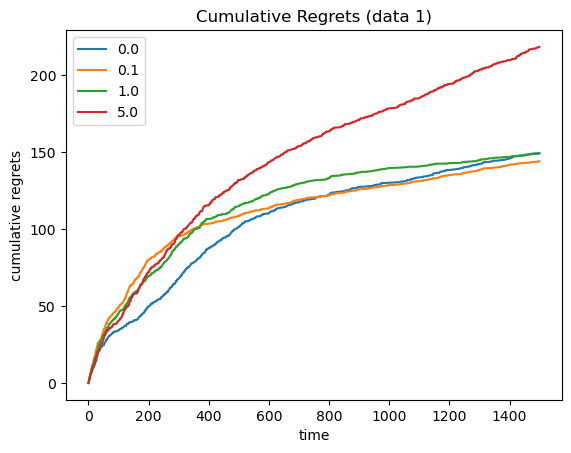

In [7]:
for alpha in alpha_list:
    plt.plot(np.cumsum(regret_result[alpha]), label=str(alpha))
    
plt.title('Cumulative Regrets (data 1)')
plt.xlabel('time')
plt.ylabel('cumulative regrets')
plt.legend()

# synthetic dataset 2 : Non-linear payoffs (monotonic)

In [8]:
np.random.seed(seed)
X = np.random.random((M,d)) - 0.5
beta = np.random.random(d)
print(beta)
Y = np.exp(X @ beta) + sigma * np.random.randn(M) #add gaussian noise

[0.31846122 0.6002861  0.1257153  0.3436361  0.74438795 0.7809338
 0.82540155 0.15316603 0.49612883 0.20603748]


In [9]:
alpha_list = [0.0, 0.1, 1.0, 5.0]
regret_result = {}
for alpha in alpha_list:
    bandit = LinUCB(d=d, alpha=alpha)
    seed=1
    np.random.seed(seed)
    regrets = []

    for t in range(T):
        ind = np.random.randint(0,M,N)
        context = [X[i,:].squeeze() for i in ind]
        exp_rewards = [x @ beta for x in context]
        label = Y[ind]   
        action = bandit.select_ac(context)       
        reward = label[action]

        bandit.update(context[action], reward)
        regrets.append(np.max(exp_rewards)-exp_rewards[action])

        if not mute:
            print(f'round {t+1}, action chosen : {action}, max reward : {np.max(exp_rewards):.3f}, reward : {reward:.3f}, regret : {regrets[-1]:.3f}, cum.regret : {np.sum(regrets):.3f}')
        
        regret_result[alpha] = regrets

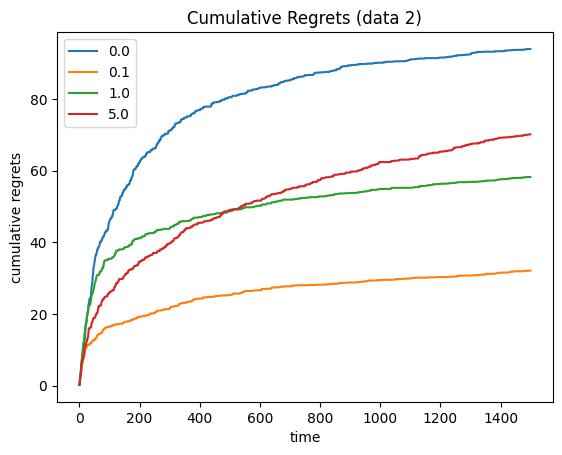

In [10]:
for alpha in alpha_list:
    plt.plot(np.cumsum(regret_result[alpha]), label=str(alpha))
    
plt.title('Cumulative Regrets (data 2)')
plt.xlabel('time')
plt.ylabel('cumulative regrets')
plt.legend()

* the true model is non-linear in X, but LinUCB still find the optimal arms.

# synthetic dataset 3 : Non-linear payoffs (non-monotonic)

In [11]:
np.random.seed(seed)
X = np.random.random((M,d)) - 0.5
beta = np.random.random(d)
print(beta)
Y = np.cos(2.*X @ beta) + sigma * np.random.randn(M) #add gaussian noise

[0.31846122 0.6002861  0.1257153  0.3436361  0.74438795 0.7809338
 0.82540155 0.15316603 0.49612883 0.20603748]


In [12]:
alpha_list = [0.0, 0.1, 1.0, 5.0]
regret_result = {}
for alpha in alpha_list:
    bandit = LinUCB(d=d, alpha=alpha)
    seed=1
    np.random.seed(seed)
    regrets = []

    for t in range(T):
        ind = np.random.randint(0,M,N)
        context = [X[i,:].squeeze() for i in ind]
        exp_rewards = [x @ beta for x in context]
        label = Y[ind]   
        action = bandit.select_ac(context)       
        reward = label[action]

        bandit.update(context[action], reward)
        regrets.append(np.max(exp_rewards)-exp_rewards[action])

        if not mute:
            print(f'round {t+1}, action chosen : {action}, max reward : {np.max(exp_rewards):.3f}, reward : {reward:.3f}, regret : {regrets[-1]:.3f}, cum.regret : {np.sum(regrets):.3f}')
        
        regret_result[alpha] = regrets

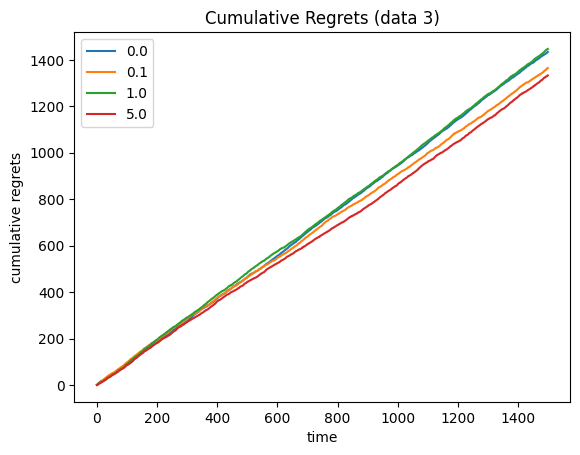

In [13]:
for alpha in alpha_list:
    plt.plot(np.cumsum(regret_result[alpha]), label=str(alpha))
    
plt.title('Cumulative Regrets (data 3)')
plt.xlabel('time')
plt.ylabel('cumulative regrets')
plt.legend()

* LinearUCB fails to find optimal arms when the the true model is non-linear to X(beta), due to the limit of the model's expressivity!

* Need more complex models - genealized linear bandits, Neural bandits, ...
* Similar implementation in practice, but regret analysis is much more difficult.

* LinUCB with feature vectors, not X itself : how to find the suitable features?


## Non-contextual UCB

* Can we view the original UCB algorithm as a special case of LinUCB?
* We can verify it with a new simulation.

### Scenario : 10 arms with Gaussian rewards

* 10 arms with mean reward [-1.0,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.0] and std 0.2.

In [14]:
mean = [-1.0,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.0]
N = len(mean)
std = 0.2
T=500
seed=0
mute = False

* consider fixed context for each arm : (1,0,0,...,0) for arm 1, (0,1,0,...,0) for arm 2, ... and true $\beta$ = mean vector

In [15]:
alpha_list = [0.0, 1.0, 5.0]
regret_result = {}
for alpha in alpha_list:
    print(f'alpha={alpha}')
    bandit = LinUCB(d=N, alpha=alpha)
    seed=1
    np.random.seed(seed)
    regrets = []

    for t in range(T):
        context = [np.eye(N)[i,:].squeeze() for i in range(N)]
        exp_rewards = mean
        action = bandit.select_ac(context)       
        reward = mean[action] + std * np.random.random()

        bandit.update(context[action], reward)
        regrets.append(np.max(exp_rewards)-exp_rewards[action])

        if not mute:
            if (t+1)%100==0:
                print(f'round {t+1}, action chosen : {action}, max reward : {np.max(exp_rewards):.3f}, reward : {reward:.3f}, regret : {regrets[-1]:.3f}, cum.regret : {np.sum(regrets):.3f}')
        
        regret_result[alpha] = regrets
        asd = bandit.beta_hat

alpha=0.0
round 100, action chosen : 5, max reward : 1.000, reward : 0.231, regret : 0.800, cum.regret : 80.000
round 200, action chosen : 5, max reward : 1.000, reward : 0.280, regret : 0.800, cum.regret : 160.000
round 300, action chosen : 5, max reward : 1.000, reward : 0.256, regret : 0.800, cum.regret : 240.000
round 400, action chosen : 5, max reward : 1.000, reward : 0.244, regret : 0.800, cum.regret : 320.000
round 500, action chosen : 5, max reward : 1.000, reward : 0.226, regret : 0.800, cum.regret : 400.000
alpha=1.0
round 100, action chosen : 8, max reward : 1.000, reward : 0.982, regret : 0.200, cum.regret : 23.200
round 200, action chosen : 9, max reward : 1.000, reward : 1.078, regret : 0.000, cum.regret : 31.400
round 300, action chosen : 8, max reward : 1.000, reward : 0.832, regret : 0.200, cum.regret : 38.200
round 400, action chosen : 9, max reward : 1.000, reward : 1.093, regret : 0.000, cum.regret : 44.800
round 500, action chosen : 9, max reward : 1.000, reward :

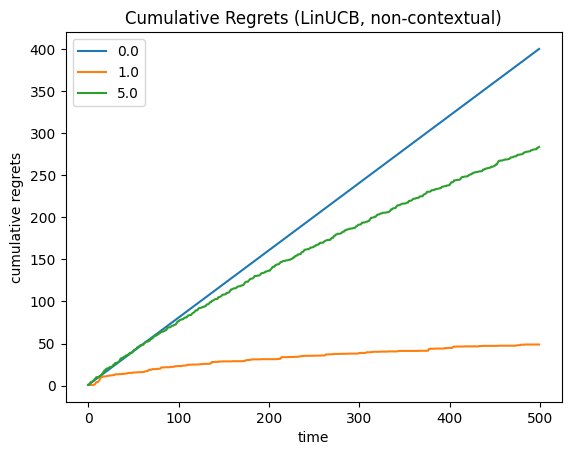

In [16]:
for alpha in alpha_list:
    plt.plot(np.cumsum(regret_result[alpha]), label=str(alpha))
    
plt.title('Cumulative Regrets (LinUCB, non-contextual)')
plt.xlabel('time')
plt.ylabel('cumulative regrets')
plt.legend()

In [17]:
class UCB:
    def __init__(self,N,alpha):
        ##Initialization
        self.t=0
        self.N=N
        self.alpha = alpha
        self.est=np.zeros(N)
        self.count = np.ones(N)
        
        '''
        N : # of arms
        t : steps taken
        
        '''
    def select_ac(self):
        self.t = self.t + 1
        try:
            est= self.est + self.alpha*np.sqrt(np.log(self.t)/self.count)
            a_t=np.random.choice(np.where(est == est.max())[0])
        except: #random choice
            a_t = np.random.choice(N)

        self.action = a_t
        return(self.action)

    def update(self, action, reward):
        self.est[action] = (self.est[action] * self.count[action] + reward) / (self.count[action]+1.)
        self.count[action]+=1.

* for simplicity, we assume that we have already pulled each arm once. i.e., set bandit.count = [1,1,1,...,1].

In [18]:
alpha_list = [0.0, 1.0, 5.0]
regret_result = {}
for alpha in alpha_list:
    print(f'alpha:{alpha}')
    bandit = UCB(N=10, alpha=alpha)
    seed=1
    np.random.seed(seed)
    regrets = []

    for t in range(T):
        action = bandit.select_ac()
        reward = mean[action] + std * np.random.randn()

        bandit.update(action, reward)
        regrets.append(np.max(mean)-mean[action])
        
        if not mute:
            if (t+1)%100==0:
                print(f'round {t+1}, action chosen : {action}, max reward : {np.max(mean):.3f}, reward : {reward:.3f}, regret : {regrets[-1]:.3f}, cum.regret : {np.sum(regrets):.3f}')
        
        regret_result[alpha] = regrets

alpha:0.0
round 100, action chosen : 5, max reward : 1.000, reward : 0.153, regret : 0.800, cum.regret : 80.000
round 200, action chosen : 5, max reward : 1.000, reward : 0.284, regret : 0.800, cum.regret : 160.000
round 300, action chosen : 5, max reward : 1.000, reward : -0.043, regret : 0.800, cum.regret : 240.000
round 400, action chosen : 5, max reward : 1.000, reward : 0.373, regret : 0.800, cum.regret : 320.000
round 500, action chosen : 5, max reward : 1.000, reward : 0.047, regret : 0.800, cum.regret : 400.000
alpha:1.0
round 100, action chosen : 9, max reward : 1.000, reward : 0.932, regret : 0.000, cum.regret : 24.400
round 200, action chosen : 9, max reward : 1.000, reward : 0.758, regret : 0.000, cum.regret : 33.200
round 300, action chosen : 9, max reward : 1.000, reward : 0.987, regret : 0.000, cum.regret : 42.200
round 400, action chosen : 9, max reward : 1.000, reward : 0.751, regret : 0.000, cum.regret : 48.800
round 500, action chosen : 9, max reward : 1.000, reward 

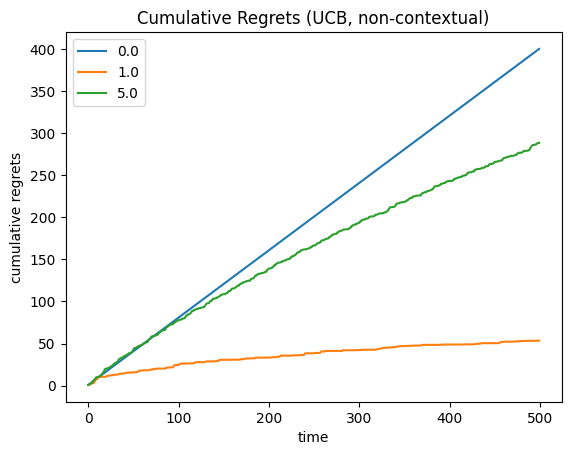

In [19]:
for alpha in alpha_list:
    plt.plot(np.cumsum(regret_result[alpha]), label=str(alpha))
    
plt.title('Cumulative Regrets (UCB, non-contextual)')
plt.xlabel('time')
plt.ylabel('cumulative regrets')
plt.legend()

* We can see that the cumulative regret graphs for UCB algorithm and for LinUCB algorithm are similar.
* Not exactly the same, due to the randomness like gaussian noise.
* The matrix from LinUCB algorithm is diagonal in this case, so we estimate the mean reward of each arm independently.
* This is the way how the original UCB algorithm works.

### Change of Environment

#### Case 1 : mean reward doubles after T=100

In [20]:
mean = [-1.0,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.0]
T=600
std=0.2
alpha_list = [0.0, 1.0, 5.0]
regret_result = {}
for alpha in alpha_list:
    print(f'alpha:{alpha}')
    bandit = UCB(N=10, alpha=alpha)
    seed=1
    np.random.seed(seed)
    regrets = []

    for t in range(T):
        
        if t==int(T/6):
            mean = 2*np.array(mean)
        
        action = bandit.select_ac()
        reward = mean[action] + std * np.random.randn()

        bandit.update(action, reward)
        regrets.append(np.max(mean)-mean[action])
        
        if not mute:
            if (t+1)%100==0:
                print(f'round {t+1}, action chosen : {action}, max reward : {np.max(mean):.3f}, reward : {reward:.3f}, regret : {regrets[-1]:.3f}, cum.regret : {np.sum(regrets):.3f}')
        
        regret_result[alpha] = regrets

alpha:0.0
round 100, action chosen : 5, max reward : 1.000, reward : 0.153, regret : 0.800, cum.regret : 80.000
round 200, action chosen : 5, max reward : 2.000, reward : 0.484, regret : 1.600, cum.regret : 240.000
round 300, action chosen : 5, max reward : 2.000, reward : 0.157, regret : 1.600, cum.regret : 400.000
round 400, action chosen : 5, max reward : 2.000, reward : 0.573, regret : 1.600, cum.regret : 560.000
round 500, action chosen : 5, max reward : 2.000, reward : 0.247, regret : 1.600, cum.regret : 720.000
round 600, action chosen : 5, max reward : 2.000, reward : 0.294, regret : 1.600, cum.regret : 880.000
alpha:1.0
round 100, action chosen : 9, max reward : 2.000, reward : 2.348, regret : 0.000, cum.regret : 31.200
round 200, action chosen : 9, max reward : 4.000, reward : 3.820, regret : 0.000, cum.regret : 31.200
round 300, action chosen : 9, max reward : 4.000, reward : 4.009, regret : 0.000, cum.regret : 31.200
round 400, action chosen : 9, max reward : 4.000, reward 

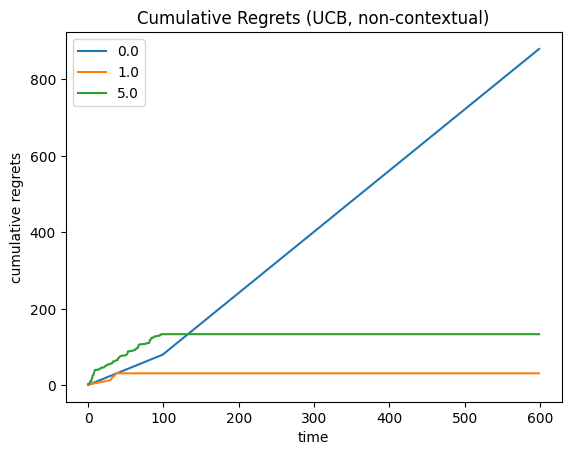

In [21]:
for alpha in alpha_list:
    plt.plot(np.cumsum(regret_result[alpha]), label=str(alpha))
    
plt.title('Cumulative Regrets (UCB, non-contextual)')
plt.xlabel('time')
plt.ylabel('cumulative regrets')
plt.legend()

* Even after the changing point, the graph dosen't change much.
* Best arm is still the best, worst arm is still the worst. (Order does not change)
* $\alpha=5.0$ fails to find optimal arm before the change, but after the change succeeds as the gap between each arm's reward increases.

#### Case 2 : the sign of mean reward is reversed after T=100

* much more drastic change
* The best arm becomes the worst arm and vice versa.

In [22]:
mean = [-1.0,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.0]
std=0.2
alpha_list = [0.0, 1.0, 5.0]
regret_result = {}
for alpha in alpha_list:
    print(f'alpha:{alpha}')
    bandit = UCB(N=10, alpha=alpha)
    seed=1
    np.random.seed(seed)
    regrets = []

    for t in range(T):
        
        if t==int(T/6):
            mean = -np.array(mean)
        
        action = bandit.select_ac()
        reward = mean[action] + std * np.random.randn()

        bandit.update(action, reward)
        regrets.append(np.max(mean)-mean[action])
        
        if not mute:
            if (t+1)%10==0:
                print(f'round {t+1}, action chosen : {action}, max reward : {np.max(mean):.3f}, reward : {reward:.3f}, regret : {regrets[-1]:.3f}, cum.regret : {np.sum(regrets):.3f}')
        
        regret_result[alpha] = regrets

alpha:0.0
round 10, action chosen : 5, max reward : 1.000, reward : 0.214, regret : 0.800, cum.regret : 8.000
round 20, action chosen : 5, max reward : 1.000, reward : 0.355, regret : 0.800, cum.regret : 16.000
round 30, action chosen : 5, max reward : 1.000, reward : 0.476, regret : 0.800, cum.regret : 24.000
round 40, action chosen : 5, max reward : 1.000, reward : -0.008, regret : 0.800, cum.regret : 32.000
round 50, action chosen : 5, max reward : 1.000, reward : 0.210, regret : 0.800, cum.regret : 40.000
round 60, action chosen : 5, max reward : 1.000, reward : 0.305, regret : 0.800, cum.regret : 48.000
round 70, action chosen : 5, max reward : 1.000, reward : 0.055, regret : 0.800, cum.regret : 56.000
round 80, action chosen : 5, max reward : 1.000, reward : 0.287, regret : 0.800, cum.regret : 64.000
round 90, action chosen : 5, max reward : 1.000, reward : 0.218, regret : 0.800, cum.regret : 72.000
round 100, action chosen : 5, max reward : 1.000, reward : 0.153, regret : 0.800,

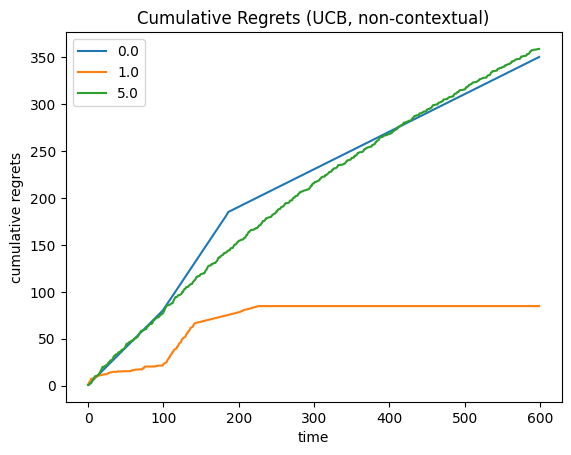

In [23]:
for alpha in alpha_list:
    plt.plot(np.cumsum(regret_result[alpha]), label=str(alpha))
    
plt.title('Cumulative Regrets (UCB, non-contextual)')
plt.xlabel('time')
plt.ylabel('cumulative regrets')
plt.legend()

* for proper value of $\alpha$(=1.0), after the changing point the model fails for some round but eventually finds the optimal arm again.
* for other values of $\alpha$, the models fails to converge to the optimal arm.